<a href="https://colab.research.google.com/github/nickchak21/QuarkGluonClassifiers/blob/master/Executable_Colab_Notebooks/SIM_particle_distribution_by_event.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the energyflow and h5py packages in the Colab environment

In [1]:
!pip install energyflow
!pip install h5py

     |████████████████████████████████| 696kB 2.8MB/s 
     |████████████████████████████████| 2.9MB 15.1MB/s 
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


Checking the version of Python (should be Python 3.6)

In [2]:
!python --version

Python 3.6.9


Installing POT (Python Optimal Transform) package

In [3]:
!pip install POT

     |████████████████████████████████| 307kB 2.7MB/s 


In [4]:
%tensorflow_version 1.x #specifies that we want to use TensorFlow 1 (the default on Colab is going to switch soon)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x #specifies that we want to use TensorFlow 1 (the default on Colab is going to switch soon)`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Import all necessary packages

In [0]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

# attempt to import sklearn
try:
    from sklearn.metrics import roc_auc_score, roc_curve
except:
    print('please install scikit-learn in order to make ROC curves')
    roc_curve = False

# attempt to import matplotlib
try:
    import matplotlib.pyplot as plt
except:
    print('please install matplotlib in order to make plots')
    plt = False


Load particle distribution from CMS Open Data

In [7]:
# load data
specs = ['375 <= corr_jet_pts <= 425', 'abs_jet_eta < 1.9', 'quality >= 2']
amount = 0.2
sim = ef.mod.load(*specs, dataset='sim', amount=amount)
print("Number of jets: ", len(sim))

print("Max: ", np.amax(sim.jet_ms))
print("Min: ", np.amin(sim.jet_ms))

Number of jets:  504909
Max:  143.2047119
Min:  3.663904428


In [8]:
#print(sim.evns)
#print(sim.rns)
sim_numbers = set(sim.evns)
run_numbers = set(sim.rns)
#print(sim_numbers)
#print(run_numbers) #don't need to sort by run number, since they're all the same
print(len(sim_numbers))
print(len(run_numbers))

442886
1


In [9]:
print(sim.evns[2])

5091631


In [10]:
len(sim.particles[sim.jets_i[:,sim.evn]==5091631])

1

Group by events

In [0]:
event_list = []
event_masses = []
for evn_num in sim_numbers:
    event_list.append(np.asarray(sim.particles[sim.jets_i[:,sim.evn]==evn_num]))
    event_masses.append(np.asarray(sim.jet_ms[sim.jets_i[:,sim.evn]==evn_num]))

In [12]:
len(event_list)

442886

In [13]:
len(event_masses)

442886

Select events with only 2 jets in them

In [0]:
event_list_2 = []
indexes = []
i = 0
for evn in event_list:
    if len(evn) == 2:
      event_list_2.append(evn)
      indexes.append(i)
    i += 1
event_masses_2 = [event_masses[j] for j in indexes]

In [15]:
print(len(event_list_2))
print(len(event_masses_2))

58108
58108


Find min and max event mass

In [16]:
sum_mass_events_2 = [sum(event_masses[j]) for j in indexes]

max_event_mass = max(sum_mass_events_2)
min_event_mass = min(sum_mass_events_2)

print("Max Event Mass: ", max_event_mass)
print("Min Event Mass: ", min_event_mass)

Max Event Mass:  218.25624846
Min Event Mass:  24.225721360999998


Divide events into mass bins - each bin is equally sized in terms of the range of masses

In [0]:
index_bin_1 = []
index_bin_2 = []
index_bin_3 = []
index_bin_4 = [] 
index_bin_5 = []

i = 0
for event_mass in sum_mass_events_2:
    if event_mass > 24.2 and event_mass <= 60.9:
        index_bin_1.append(i)
    elif event_mass > 60.9 and event_mass <= 97.6:
        index_bin_2.append(i)
    elif event_mass > 97.6 and event_mass <= 134.4:
        index_bin_3.append(i)
    elif event_mass > 134.4 and event_mass <= 171.1:
        index_bin_4.append(i)
    elif event_mass > 171.1 and event_mass <= 219:
        index_bin_5.append(i)

    i += 1

event_mass_bin1 = [event_list_2[j] for j in index_bin_1]
event_mass_bin2 = [event_list_2[j] for j in index_bin_2]
event_mass_bin3 = [event_list_2[j] for j in index_bin_3]
event_mass_bin4 = [event_list_2[j] for j in index_bin_4]
event_mass_bin5 = [event_list_2[j] for j in index_bin_5]

Check size of each mass bin

In [18]:
print(len(event_mass_bin1))
print(len(event_mass_bin2))
print(len(event_mass_bin3))
print(len(event_mass_bin4))
print(len(event_mass_bin5))

4463
33384
16842
3175
244


In [0]:
jet_mass_bin1 = []
jet_mass_bin2 = []
jet_mass_bin3 = []
jet_mass_bin4 = []
jet_mass_bin5 = []

for event in event_mass_bin1:
    for jet in event:
        jet_mass_bin1.append(jet)

for event in event_mass_bin2:
    for jet in event:
        jet_mass_bin2.append(jet)

for event in event_mass_bin3:
    for jet in event:
        jet_mass_bin3.append(jet)

for event in event_mass_bin4:
    for jet in event:
        jet_mass_bin4.append(jet)

for event in event_mass_bin5:
    for jet in event:
        jet_mass_bin5.append(jet)

Find out max number of particles for the jets in each mass bin

In [20]:
array_lengths = []
for i in range(len(jet_mass_bin1)):
    array_lengths.append(len(jet_mass_bin1[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(jet_mass_bin2)):
    array_lengths.append(len(jet_mass_bin2[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(jet_mass_bin3)):
    array_lengths.append(len(jet_mass_bin3[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(jet_mass_bin4)):
    array_lengths.append(len(jet_mass_bin4[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(jet_mass_bin5)):
    array_lengths.append(len(jet_mass_bin5[i]))
print(max(array_lengths))

63
111
130
133
125


Pad each of the jet arrays with 0s to create a contiguous array with max_particles = 160. To run this in Colab, do two at a time and calculate the AUC, otherwise you will run out of RAM. If runtime crashes, click "Get More RAM" at the bottom and you will switch to a high RAM environment.

In [37]:
'''
jet_array_1 = np.zeros((len(jet_mass_bin1),160,6))
for i in range(len(jet_mass_bin1)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_1[i,j,k] = jet_mass_bin1[i][j][k]
            except IndexError:
                jet_array_1[i,j,k] = 0
print("Mass bin 1 done")


jet_array_2 = np.zeros((len(jet_mass_bin2),160,6))
for i in range(len(jet_mass_bin2)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_2[i,j,k] = jet_mass_bin2[i][j][k]
            except IndexError:
                jet_array_2[i,j,k] = 0
print("Mass bin 2 done")

'''

jet_array_3 = np.zeros((len(jet_mass_bin3),160,6))
for i in range(len(jet_mass_bin3)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_3[i,j,k] = jet_mass_bin3[i][j][k]
            except IndexError:
                jet_array_3[i,j,k] = 0
print("Mass bin 3 done")


jet_array_4 = np.zeros((len(jet_mass_bin4),160,6))
for i in range(len(jet_mass_bin4)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_4[i,j,k] = jet_mass_bin4[i][j][k]
            except IndexError:
                jet_array_4[i,j,k] = 0
print("Mass bin 4 done")

'''
jet_array_5 = np.zeros((len(mass_bin_5),160,6))
for i in range(len(mass_bin_5)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_5[i,j,k] = mass_bin_5[i][j][k]
            except IndexError:
                jet_array_5[i,j,k] = 0
print("Mass bin 5 done")

jet_array_6 = np.zeros((len(mass_bin_6),160,6))
for i in range(len(mass_bin_6)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_6[i,j,k] = mass_bin_6[i][j][k]
            except IndexError:
                jet_array_6[i,j,k] = 0
print("Mass bin 6 done")

jet_array_7 = np.zeros((len(mass_bin_7),160,6))
for i in range(len(mass_bin_7)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_7[i,j,k] = mass_bin_7[i][j][k]
            except IndexError:
                jet_array_7[i,j,k] = 0
print("Mass bin 7 done")

jet_array_8 = np.zeros((len(mass_bin_8),160,6))
for i in range(len(mass_bin_8)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_8[i,j,k] = mass_bin_8[i][j][k]
            except IndexError:
                jet_array_8[i,j,k] = 0
print("Mass bin 8 done")
'''

Mass bin 3 done
Mass bin 4 done


'\njet_array_5 = np.zeros((len(mass_bin_5),160,6))\nfor i in range(len(mass_bin_5)):\n    for j in range(160):\n        for k in range(6):\n            try:\n                jet_array_5[i,j,k] = mass_bin_5[i][j][k]\n            except IndexError:\n                jet_array_5[i,j,k] = 0\nprint("Mass bin 5 done")\n\njet_array_6 = np.zeros((len(mass_bin_6),160,6))\nfor i in range(len(mass_bin_6)):\n    for j in range(160):\n        for k in range(6):\n            try:\n                jet_array_6[i,j,k] = mass_bin_6[i][j][k]\n            except IndexError:\n                jet_array_6[i,j,k] = 0\nprint("Mass bin 6 done")\n\njet_array_7 = np.zeros((len(mass_bin_7),160,6))\nfor i in range(len(mass_bin_7)):\n    for j in range(160):\n        for k in range(6):\n            try:\n                jet_array_7[i,j,k] = mass_bin_7[i][j][k]\n            except IndexError:\n                jet_array_7[i,j,k] = 0\nprint("Mass bin 7 done")\n\njet_array_8 = np.zeros((len(mass_bin_8),160,6))\nfor i in 

In [29]:
len(jet_array_1)

8926

In [30]:
len(jet_array_2)

66768

Create datasets out of mass bins 1 and 2 to feed into PFN (Particle Flow Network) machine learning model

In [0]:
#Bins 1 and 2
X = np.concatenate([jet_array_1, jet_array_2])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_1)), np.zeros(len(jet_array_2))])
#del jet_array_1, jet_array_2

Run PFN model on mass bins 1 and 2 to see how well model can distinguish between jets in those bins.

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_1[0][0]           

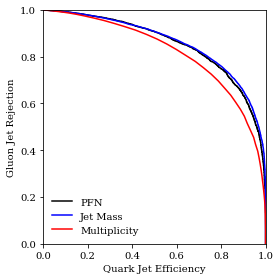

In [32]:
#Bins 1 and 2
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 30000, 20000, 25694
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 20
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Create datasets out of mass bins 2 and 3 to feed into PFN (Particle Flow Network) machine learning model

In [0]:
#Bins 2 and 3
X = np.concatenate([jet_array_2, jet_array_3])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_2)), np.zeros(len(jet_array_3))])
#del jet_array_2, jet_array_3

Run PFN model on mass bins 2 and 3 to see how well model can distinguish between jets in those bins.

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_8[0][0]               


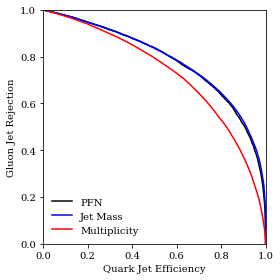

In [36]:
#Bins 2 and 3
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 30000, 30000, 40452
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 20
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Create datasets out of mass bins 3 and 4 to feed into PFN (Particle Flow Network) machine learning model

In [0]:
#Bins 3 and 4
X = np.concatenate([jet_array_3, jet_array_4])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_3)), np.zeros(len(jet_array_4))])
#del jet_array_3, jet_array_4

Run PFN model on mass bins 3 and 4 to see how well model can distinguish between jets in those bins.

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_15 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_15[0][0]              


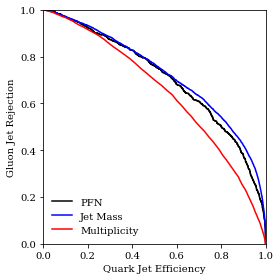

In [39]:
#Bins 3 and 4
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 30000, 4000, 6034
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 20
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

AUC plot

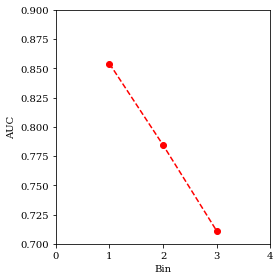

In [46]:
plt.plot([1, 2, 3], [0.8540360091868698, 0.7844014463904062, 0.7109788681441134], "r--o")
plt.axis([0, 4, 0.7, 0.9])
plt.xlabel('Bin')
plt.ylabel('AUC')
plt.show()